In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 23 kB/s 
     |████████████████████████████████| 199 kB 54.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=2932044f8c28160233ce5857ae0fb9f161926aaadbee1f360edf37fcadc2c05b
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [127]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression

warnings.filterwarnings('ignore')

# Connect to the Spark server

In [95]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# Obtain the Data

In [96]:
fullpath = 'Airline_Passenger_Satisfaction.csv'

data = spark.read.csv(fullpath)

In [97]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string]

In [98]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- CustomerType: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- TypeofTravel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- FlightDistance: integer (nullable = true)
 |-- Inflightwifiservice: integer (nullable = true)
 |-- Departure/Arrivaltimeconvenient: integer (nullable = true)
 |-- EaseofOnlinebooking: integer (nullable = true)
 |-- Gatelocation: integer (nullable = true)
 |-- Foodanddrink: integer (nullable = true)
 |-- Onlineboarding: integer (nullable = true)
 |-- Seatcomfort: integer (nullable = true)
 |-- Inflightentertainment: integer (nullable = true)
 |-- On-boardservice: integer (nullable = true)
 |-- Legroomservice: integer (nullable = true)
 |-- Baggagehandling: integer (nullable = true)
 |-- Checkinservice: integer (nullable = true)
 |-- Inflightservice: integer (nullable = true)
 |-- Cleanliness: integer (nul

# Data Cleaning

In [99]:
# these columns are useless to us, drop them
drop_cols = ['DepartureDelayinMinutes', 'ArrivalDelayinMinutes', '_c0', 'id']

data = data.drop(*drop_cols)

In [100]:
data = data.replace('other', None, subset=['Gender'])

In [101]:
data = data.replace('other', None, subset=['Class'])

# Descriptive Statistics

In [102]:
data.select('Gatelocation', 'FlightDistance','Foodanddrink','EaseofOnlinebooking','Onlineboarding',"Seatcomfort").summary().show()

+-------+------------------+------------------+------------------+-------------------+-----------------+------------------+
|summary|      Gatelocation|    FlightDistance|      Foodanddrink|EaseofOnlinebooking|   Onlineboarding|       Seatcomfort|
+-------+------------------+------------------+------------------+-------------------+-----------------+------------------+
|  count|            103904|            103904|            103904|             103904|           103904|            103904|
|   mean|2.9768825069294733|1189.4483754234677|3.2021288882044963| 2.7569006005543577|3.250375346473668|3.4393959809054513|
| stddev|1.2776210103002335| 997.1472805289565| 1.329532710858201|  1.398929472659151|1.349508953713335|1.3190875186173359|
|    min|                 0|                31|                 0|                  0|                0|                 0|
|    25%|                 2|               414|                 2|                  2|                2|                 2|
|    50%

In [103]:
# both columns starts with 0, log(0) is undefined so we should put +1
data = data.withColumn('FlightDistance', F.log10(F.col('FlightDistance') + 1))
data = data.withColumn('Foodanddrink', F.log10(F.col('Foodanddrink') + 1))
data = data.withColumn('Onlineboarding', F.log10(F.col('Onlineboarding') + 1))


In [104]:
data.select('Gatelocation', 'FlightDistance','Foodanddrink','EaseofOnlinebooking','Onlineboarding',"Seatcomfort").summary().show()

+-------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary|      Gatelocation|     FlightDistance|       Foodanddrink|EaseofOnlinebooking|     Onlineboarding|       Seatcomfort|
+-------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|            103904|             103904|             103904|             103904|             103904|            103904|
|   mean|2.9768825069294733| 2.9122031753244495| 0.5983436748840335| 2.7569006005543577| 0.5997603408048525|3.4393959809054513|
| stddev|1.2776210103002335|0.39763564081712566|0.15401069513744203|  1.398929472659151|0.17141138425855798|1.3190875186173359|
|    min|                 0|  1.505149978319906|                0.0|                  0|                0.0|                 0|
|    25%|                 2| 2.6180480967120925|0.47712125471966244|                  2|0.47712125471966

# Data Exploration

In [105]:
data.registerTempTable('data')

state_counts = spark.sql(r"""SELECT Gender, COUNT(Gender) AS total 
                                     FROM data 
                                     GROUP BY Gender 
                                     ORDER BY total desc """)
state_counts.show()

+------+-----+
|Gender|total|
+------+-----+
|Female|52727|
|  Male|51177|
+------+-----+



In [106]:
mfr_counts = spark.sql(r"""SELECT Class, COUNT(Class) as total
                                  FROM data
                                  GROUP BY Class
                                  ORDER BY total desc""")

mfr_counts.show()

+--------+-----+
|   Class|total|
+--------+-----+
|Business|49665|
|     Eco|46745|
|Eco Plus| 7494|
+--------+-----+



Value indicating if the satisfaction was satisfied (1) or neutral or dissatisfied (0)

In [107]:
mfr_counts = spark.sql(r"""SELECT satisfaction, COUNT(satisfaction) as total
                                  FROM data
                                  GROUP BY satisfaction
                                  ORDER BY total desc""")

mfr_counts.show()

+------------+-----+
|satisfaction|total|
+------------+-----+
|           0|58879|
|           1|45025|
+------------+-----+



In [108]:
mfr_counts = spark.sql(r"""SELECT CustomerType, COUNT(CustomerType) as total
                                  FROM data
                                  GROUP BY CustomerType
                                  ORDER BY total desc""")

mfr_counts.show()

+-----------------+-----+
|     CustomerType|total|
+-----------------+-----+
|   Loyal Customer|84923|
|disloyal Customer|18981|
+-----------------+-----+



# visualization

In [109]:

df_result = spark.sql('SELECT Class, Age FROM data WHERE Class IN ("Business", "Eco")')
df_result = df_result.toPandas()

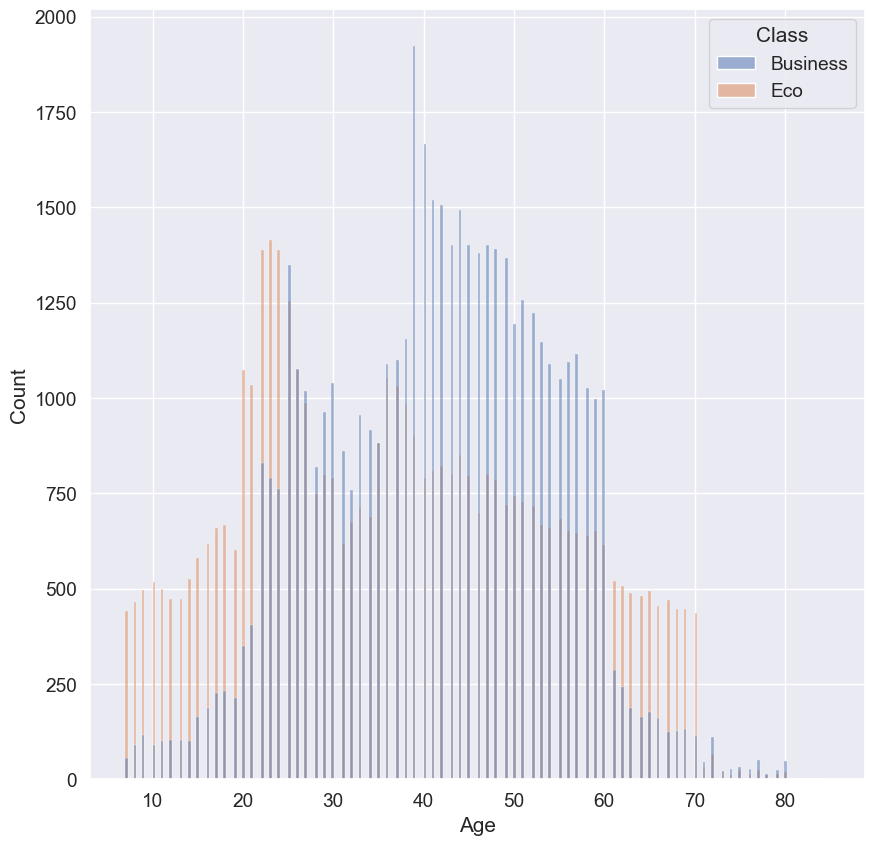

In [110]:
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_result, x='Age', hue='Class', binwidth=0.3)
sns.set(rc={'figure.figsize':(10,10)})

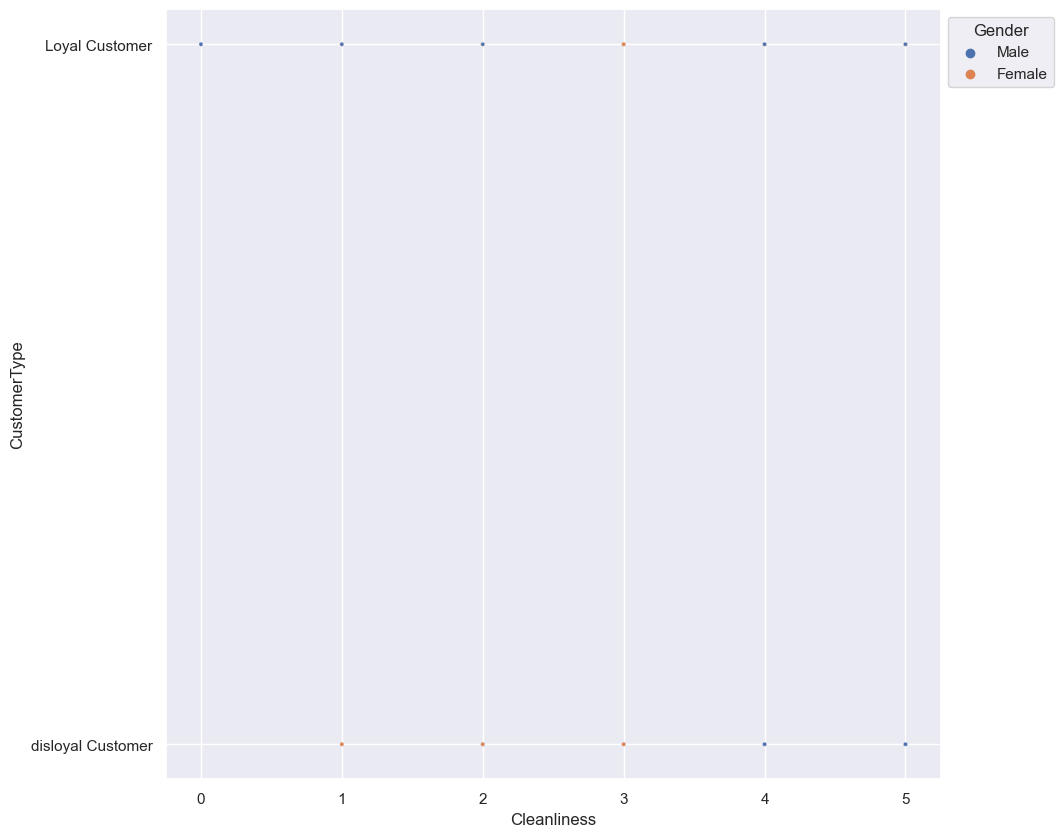

In [111]:
df_result = spark.sql('SELECT Gender, Cleanliness, CustomerType FROM data')
df_result = df_result.toPandas()
ax = sns.scatterplot(data=df_result, x='Cleanliness', y='CustomerType', hue='Gender', s=8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.set(rc={'figure.figsize':(10,5)})

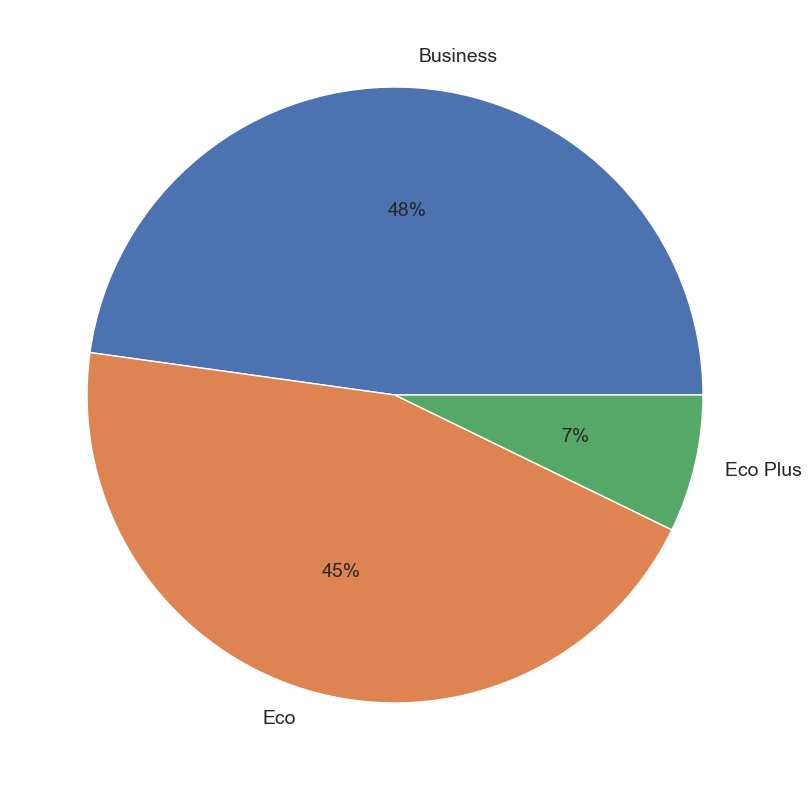

In [112]:
df_result = spark.sql('SELECT Class FROM data')
df_result = df_result.toPandas()
df_result_c = df_result['Class'].value_counts().nlargest(4)
colors = sns.color_palette('deep')
sns.set(rc={'figure.figsize':(10,10)})
plt.pie(df_result_c.values, labels=df_result_c.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

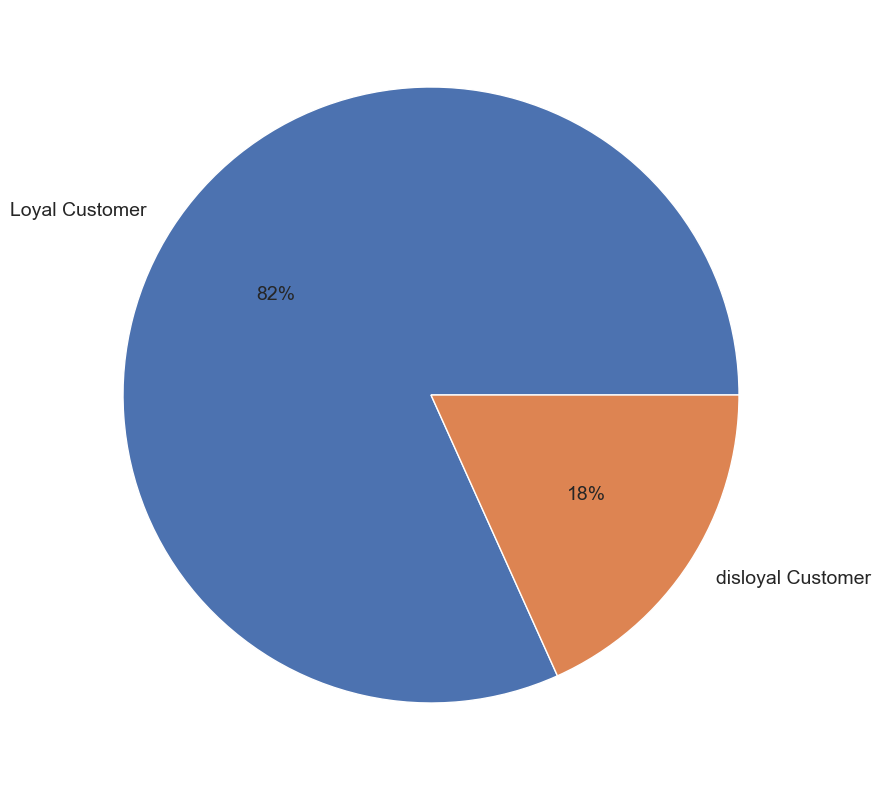

In [113]:

df_result = spark.sql('SELECT CustomerType FROM data')
df_result = df_result.toPandas()
df_result_c = df_result['CustomerType'].value_counts().nlargest(4)
colors = sns.color_palette('deep')
sns.set(rc={'figure.figsize':(10,10)})
plt.pie(df_result_c.values, labels=df_result_c.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

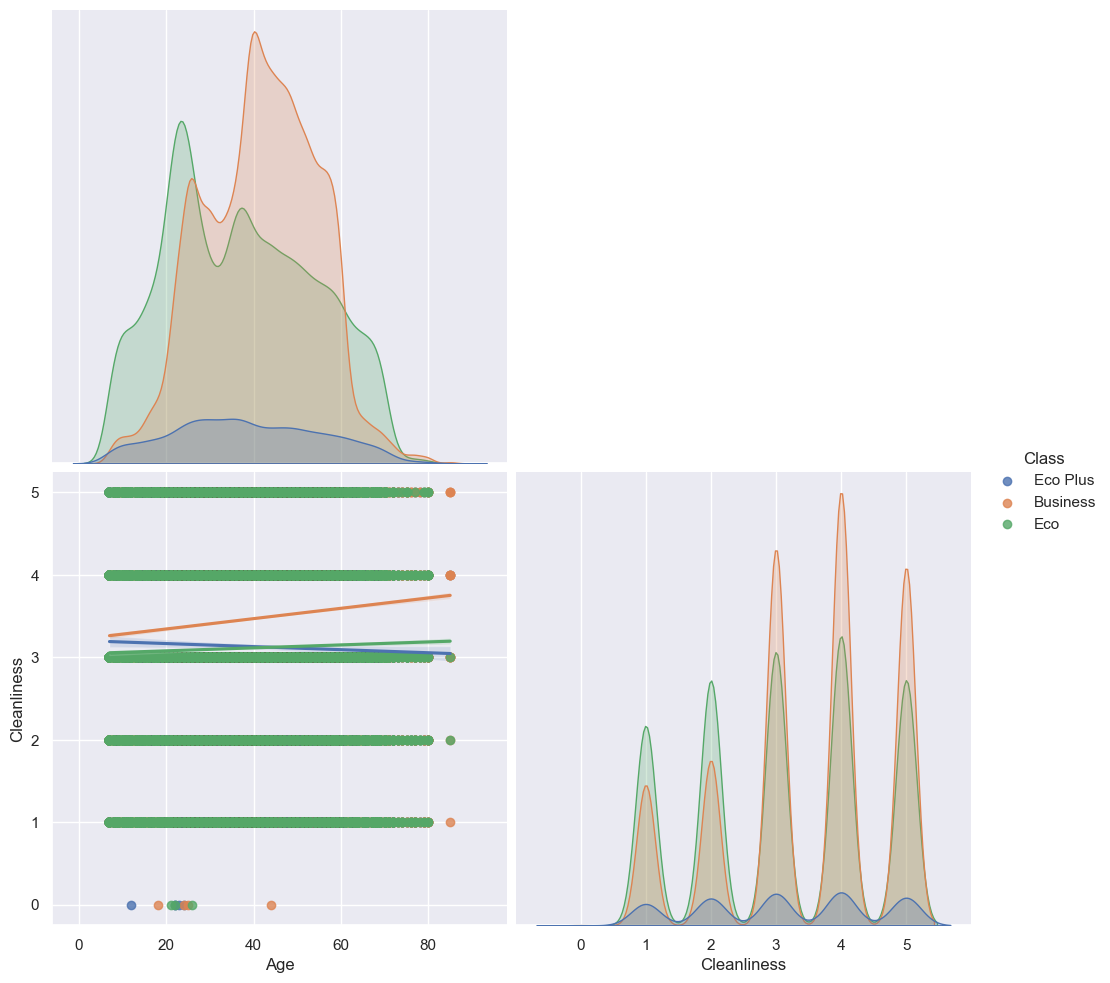

In [114]:
df_result = spark.sql('SELECT Class, Age, Gender, Cleanliness FROM data')
df_result = df_result.toPandas()
sns.pairplot(df_result, kind='reg', hue='Class', corner=True, size=5)

# Data Preparation for ML

Category Dropping

In [115]:
cat_cols = ['Gender', 'CustomerType', 'TypeofTravel', 'Class','satisfaction']

n = 4

for col in cat_cols:
    most_freq = data.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    data = data.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

Imputation using mean for null values .. > we dont have missing values

In [58]:
# num_cols = ['Age', 'FlightDistance', 'Inflightwifiservice', 'Departure/Arrivaltimeconvenient', 'EaseofOnlinebooking', 'Gatelocation', 'Foodanddrink', 'Onlineboarding', 'Seatcomfort', 'Inflightentertainment', 'On-boardservice', 'Legroomservice', 'Baggagehandling', 'Checkinservice', 'Inflightservice', 'Cleanliness',"satisfaction"]

# imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
# model = imputer.fit(data)
# data = model.transform(data)
# replace nulls withe unknown 
# data = data.fillna('unknown', subset=cat_cols)

encode the categracal coulmn and drop the oregenal one 

In [116]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    data = indexer.fit(data).transform(data)
    
data = data.drop(*cat_cols)

# Combining Feature Columns

In [119]:
cols = data.columns
cols.remove('satisfaction_idx') #remove -> we need this to be our label


assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

In [120]:
# We have created a new dataframe only consisting of the features column and the label column (actually price column but renamed)
df_data = data.select(F.col('features'), F.col('satisfaction_idx').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

# Model Building

In [121]:
evaluator = RegressionEvaluator() # Can specify what metrics we want to use. Default metric is Root Mean Squared Error (RMSE)
grid = ParamGridBuilder().build()

# Initialize Regressors and Train

In [122]:
#Random Forest Regressor
classifier_rf = RandomForestRegressor(featuresCol='features', labelCol='label')
cv_rf = CrossValidator(estimator=classifier_rf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_rf = cv_rf.fit(df_train)

In [123]:
#Gradient Boosted Tree Regressor
classifier_gbt = GBTRegressor(featuresCol="features", labelCol='label', maxIter=10)
cv_gbt = CrossValidator(estimator=classifier_gbt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_gbt = cv_gbt.fit(df_train)

In [148]:
#Linear Regression
classifier_lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
cv_lr = CrossValidator(estimator=classifier_lr, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_lr = cv_lr.fit(df_train)

# Evaluation

In [ ]:
metrics = []
models = [cv_model_rf, cv_model_gbt, cv_model_lr]

for model in models:
    metrics.append(model.avgMetrics)
print (metrics)

for idx, model in enumerate(models): 
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='mae').evaluate(model.bestModel.transform(df_test)))

df = pd.DataFrame(metrics, index = ['Random Forest Regressor', 'Gradient Boosted Tree Regressor',  'Linear Regression'], columns=['Average Metrics (CV)', 'Best Model R2 on Test Set', 'Best Model RMSE on Test Set', 'Best Model MAE on Test Set'])

df